In [67]:
import random
import time
import pygame
import numpy as np
from pygame.locals import *
from pygame.color import *
import pymunk
from pymunk import Vec2d
import pymunk.pygame_util
import csv
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

# Some general variables -- you don't need to change any of these
N_BLOCKS = 6 # How many blocks will fall?
BLOCK_SIZE = 20 # How big are the blocks?
deltaY     = 35 # How far spaced out vertically are they?
xSD        = 30.0 # What is the SD for their x-locations?
FPS = 30. # how many frames per second do we run?
BLOCK_MASS = 1.0
BLOCK_FRICTION = 1.0
FLOOR = 100
RUN_TIME = 10.0 # Time in seconds that we will run a simulation for
STEPS_PER_FRAME = 5.0 # Do not change this
WIDTH = 600 # Screen dimensions -- don't change
HEIGHT = 600

class BlockTower:
    # Implement a class to show/simulate blocks falling via pymunk
    # Note: this code has been modified from the pymunk pyramid demo

    def __init__(self, positions):
        # The intializer takes a list of x-positions for blocks; their height is set
        # by the code here.
        assert(len(positions)==N_BLOCKS) # can't give more than N_BLOCKS since we need to draw them

        self.positions = positions # store the positions of our blocks

        # Set up some pygame stuff
        self.running = True
        self.physics_running = False
        self.start_time = 0
        self.drawing = True
        self.w, self.h = WIDTH,HEIGHT
        self.screen = pygame.display.set_mode((self.w, self.h))
        self.clock = pygame.time.Clock()

        ### Init pymunk and create space
        self.space = pymunk.Space()
        self.space.gravity = (0.0, -900.0)
        self.space.sleep_time_threshold = 0.3

        self.floor = pymunk.Segment(self.space.static_body, (0, FLOOR), (self.w,FLOOR), 1.0)
        self.floor.friction = 1.0
        self.space.add(self.floor)

        # Draw each block and add it to the physics
        for i in range(N_BLOCKS):
            points = [(-BLOCK_SIZE, -BLOCK_SIZE), (-BLOCK_SIZE, BLOCK_SIZE), (BLOCK_SIZE,BLOCK_SIZE), (BLOCK_SIZE, -BLOCK_SIZE)]
            moment = pymunk.moment_for_poly(BLOCK_MASS, points, (0,0))
            body = pymunk.Body(BLOCK_MASS, moment)
            xpos = self.positions[i]
            ypos = FLOOR + (2*i+1) * deltaY
            body.position = Vec2d(xpos,ypos)
            shape = pymunk.Poly(body, points)
            if(i == N_BLOCKS-1):     # color the top
                shape.color = (1,0,0,1)
                self.target_block = shape # store the top one we are tracking
            shape.friction = 1
            self.space.add(body,shape)

        ### draw options for drawing
        self.draw_options = pymunk.pygame_util.DrawOptions(self.screen)

    def is_black_block_on_floor(self):
        # Returns true or false depending on whether the black block is on the bottom
        col = self.target_block.shapes_collide(self.floor) # this resturns a ContactPointSet
        return len(col.points) > 0

    def run_person(self):
        # Show a window where people can predict yes/no (y/n) for whether the black block hits the bottom.
        # After they respond, they can observe the physics.
        # Rteturns their prediction and whether the black block actually hit the floor

        prediction = None # what people predicted?

        # Call this to run a single simulation with the given positions
        while self.running and (time.time() - self.start_time) < RUN_TIME or self.start_time==0:
            for event in pygame.event.get():
                if event.type == QUIT:
                    self.running = False
                elif event.type == KEYDOWN and event.key == K_ESCAPE:
                    self.running = False
                elif event.type == KEYDOWN and (event.key == K_y or event.key==K_n):  ## This detects a space press and starts simulating
                    prediction = (event.key == K_y)
                    self.physics_running = True
                    self.start_time = time.time()  # remember the time that physics started running

            if self.physics_running:
                self.space.step(1.0 / FPS / STEPS_PER_FRAME)  ## conveera frames per second to internal clock tics -- don't change!

            if self.drawing:
                self.draw()

            self.clock.tick(FPS) # don't let this loop run faster than FPS
        return (prediction, self.is_black_block_on_floor())
    
    def change_x_y(self, new_x):
        # This is what you should call instead of initializing new objects
        # this resets the y-positions and puts the blocks at the specified x positions
        self.space.remove(self.space.bodies)
        self.__init__(new_x)

    def simulate(self):
        # Just run a simulation, returning whether after 10s the black block hits the floor
        for s in range(int(FPS*5*RUN_TIME)): # run for 10s
            self.space.step(1.0 / FPS / STEPS_PER_FRAME) # run this many steps
        return self.is_black_block_on_floor()

    def draw(self):
        ### This gets called to draw the scene

        ### Clear the screen
        self.screen.fill(THECOLORS["white"])

        ### Draw space  with our given options
        self.space.debug_draw(self.draw_options)

        ### All done, lets flip the display, which will cause it to be displayed
        pygame.display.flip()
    
    def saveimage(self, file="screenshot.jpg"):
        ### This gets called to draw the scene

        ### Clear the screen
        self.screen.fill(THECOLORS["white"])

        ### Draw space  with our given options
        self.space.debug_draw(self.draw_options)

        ## Save to a file
        pygame.image.save(self.screen, file)

# Problem 1

In [14]:
#############################################################################################
###   Code block commented out so I don't accidentally run it again and mess up the csv   ###
#############################################################################################


#with open('predictions_test.csv', mode='w') as csv_file: 
    
    fieldnames = ['Count' ,'Position1', 'Position2', 'Position3', 'Position4', 'Position5', 'Position6',\
                  'Prediction', 'Result']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    
    count = 1
    #for i in range(200): #Number of trials
        pos = [numpy.random.normal(WIDTH/2, xSD) for _ in range(N_BLOCKS)]
        #demo2 = BlockTower(pos)
        result = demo2.run_person()
        writer.writerow({"Count":count, "Position1":pos[0],\
                "Position2":pos[1], "Position3":pos[2], \
             "Position4":pos[3], "Position5":pos[4], "Position6":pos[5], \
                "Prediction":result[0], "Result":result[1]}) 
        count += 1
    pygame.quit()

In [39]:
test = pd.read_csv("predictions_test.csv")
df = pd.DataFrame(test)
df["Correct"] = df["Prediction"] == df["Result"]
print("Percentage I got Correct: " + \
      str(len(df[df["Correct"] == True])/200))
print("Number of trials: " + str(len(df["Count"])))
df.head(10)

Percentage I got Correct: 0.695
Number of trials: 200


,Count,Position1,Position2,Position3,Position4,Position5,Position6,Prediction,Result,Correct
0,1,332.687363,279.998904,300.291187,291.765831,248.976513,258.574605,False,True,False
1,2,296.778668,299.427044,309.590934,306.248083,294.444706,257.123844,True,True,True
2,3,281.587996,332.799880,324.110002,306.391861,381.402862,349.040378,True,True,True
3,4,293.507395,278.312487,343.684229,312.138322,316.612083,284.057135,True,True,True
4,5,310.362019,325.997335,267.057514,272.395291,326.373878,333.291516,True,False,False
5,6,269.203956,346.405172,287.337364,339.941263,324.974724,295.064659,True,True,True
6,7,308.071464,324.178154,321.402238,298.370827,307.143410,302.671004,False,False,True
7,8,317.549679,338.453198,259.499015,296.691151,379.103846,339.854381,False,False,True
8,9,328.777140,306.515158,290.371022,275.731152,278.587581,264.451855,True,False,False
9,10,303.828890,289.569643,240.677272,327.083178,312.418970,342.403462,True,True,True


# Problem 2

In [44]:
predictions = []
bt = BlockTower([0, 0, 0, 0, 0, 0])
start = time.time()
for i in range(200):
    iloced = df.iloc[i]
    positions = [iloced["Position1"], iloced["Position2"], \
                 iloced["Position3"], iloced["Position4"], 
                 iloced["Position5"], \
                iloced["Position6"]]
    hitdafloor = []
    for n in range(100):
        copy = positions.copy()
        copy = list(map(lambda x: x + np.random.normal(scale = 10), \
                        copy))
        bt.change_x_y(copy)
        hitdafloor.append(bt.simulate())
    predictions.append(len([i for i in hitdafloor if i == True])/\
                       len(hitdafloor)) 
end = time.time()
print("Time elapsed: " + str(start-end))

Time elapsed: -158.22923111915588


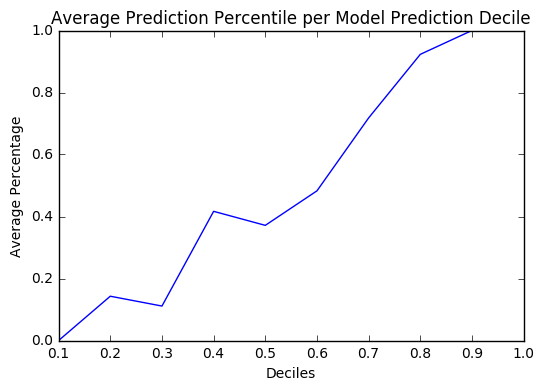

In [45]:
df["Deciles"] = predictions
df["Deciles"] = df["Deciles"].apply(lambda x: round(x, 1))
edited = df.groupby("Deciles").mean().reset_index()[["Deciles", "Prediction"]]
plt.plot(edited["Deciles"], edited["Prediction"])
plt.xlabel("Deciles")
plt.ylabel("Average Percentage")
plt.title("Average Prediction Percentile per Model Prediction Decile")

<b> A good model of me would have this graph show a near perfect x=y correlation, with my predictions matching up with the machine-made predictions. This is more or less what my graph shows, with some fluctuation (as my prediction correct rating was only around 70%). </b>

# Problem 3

Time Elapsed: 152.36479115486145


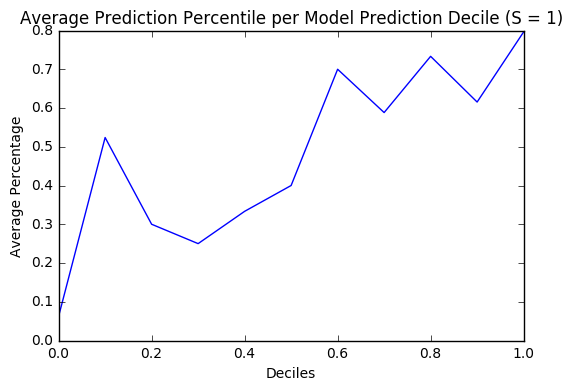

In [46]:
s = [1, 5, 10, 15, 20, 50, 100]
df = df.drop("Deciles", axis = 1)
dfcopy = df.copy()
predictions = []
bt = BlockTower([0, 0, 0, 0, 0, 0])
start = time.time()
for i in range(200):
    iloced = df.iloc[i]
    positions = [iloced["Position1"], iloced["Position2"],\
                 iloced["Position3"], iloced["Position4"], \
                 iloced["Position5"], \
                iloced["Position6"]]
    hitdafloor = []
    for n in range(100):
        copy = positions.copy()
        copy = list(map(lambda x: x + np.random.normal(scale = 1), copy))
        bt.change_x_y(copy)
        hitdafloor.append(bt.simulate())
    predictions.append(len([i for i in hitdafloor if i == True])/\
                       len(hitdafloor))  
dfcopy["Deciles"] = predictions
dfcopy["Deciles"] = dfcopy["Deciles"].apply(lambda x: round(x, 1))
edited = dfcopy.groupby("Deciles").mean().reset_index()[["Deciles", "Prediction"]]
plt.plot(edited["Deciles"], edited["Prediction"])
plt.xlabel("Deciles")
plt.ylabel("Average Percentage")
plt.title("Average Prediction Percentile per Model Prediction Decile (S = 1)")
end = time.time()
print("Time Elapsed: " + str(end - start))

Time Elapsed: 152.6687731742859


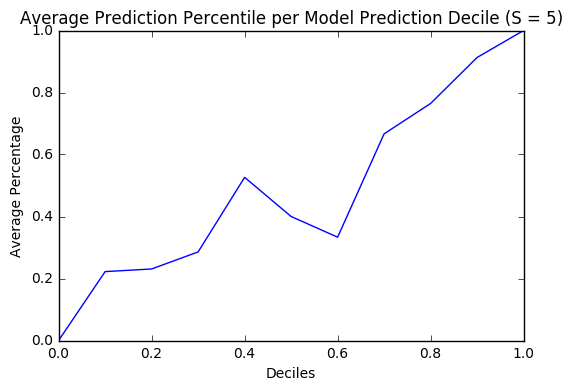

In [47]:
predictions = []
bt = BlockTower([0, 0, 0, 0, 0, 0])
start = time.time()
for i in range(200):
    iloced = df.iloc[i]
    positions = [iloced["Position1"], iloced["Position2"], iloced["Position3"], iloced["Position4"], iloced["Position5"], \
                iloced["Position6"]]
    hitdafloor = []
    for n in range(100):
        copy = positions.copy()
        copy = list(map(lambda x: x + np.random.normal(scale = 5), copy))
        bt.change_x_y(copy)
        hitdafloor.append(bt.simulate())
    predictions.append(len([i for i in hitdafloor if i == True])/len(hitdafloor))  
dfcopy["Deciles"] = predictions
dfcopy["Deciles"] = dfcopy["Deciles"].apply(lambda x: round(x, 1))
edited = dfcopy.groupby("Deciles").mean().reset_index()[["Deciles", "Prediction"]]
plt.plot(edited["Deciles"], edited["Prediction"])
plt.xlabel("Deciles")
plt.ylabel("Average Percentage")
plt.title("Average Prediction Percentile per Model Prediction Decile (S = 5)")
end = time.time()
print("Time Elapsed: " + str(end - start))

Time Elapsed: 147.7272503376007


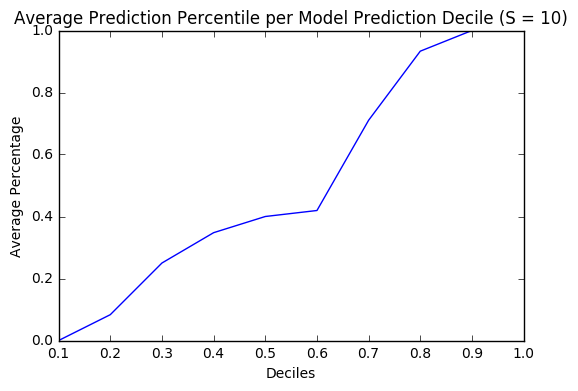

In [48]:
predictions = []
bt = BlockTower([0, 0, 0, 0, 0, 0])
start = time.time()
for i in range(200):
    iloced = df.iloc[i]
    positions = [iloced["Position1"], iloced["Position2"], iloced["Position3"], iloced["Position4"], iloced["Position5"], \
                iloced["Position6"]]
    hitdafloor = []
    for n in range(100):
        copy = positions.copy()
        copy = list(map(lambda x: x + np.random.normal(scale = s[2]), copy))
        bt.change_x_y(copy)
        hitdafloor.append(bt.simulate())
    predictions.append(len([i for i in hitdafloor if i == True])/len(hitdafloor))  
dfcopy["Deciles"] = predictions
dfcopy["Deciles"] = dfcopy["Deciles"].apply(lambda x: round(x, 1))
edited = dfcopy.groupby("Deciles").mean().reset_index()[["Deciles", "Prediction"]]
plt.plot(edited["Deciles"], edited["Prediction"])
plt.xlabel("Deciles")
plt.ylabel("Average Percentage")
plt.title("Average Prediction Percentile per Model Prediction Decile (S = 10)")
end = time.time()
print("Time Elapsed: " + str(end - start))

Time Elapsed: 148.93339347839355


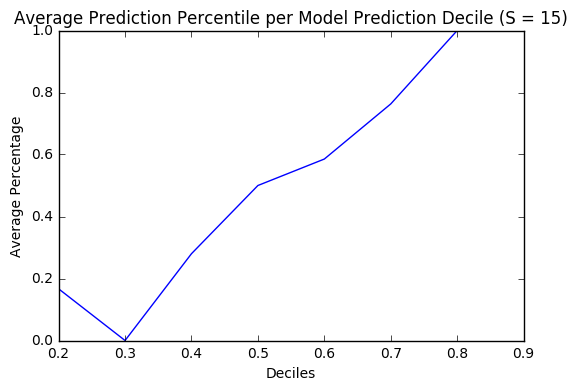

In [50]:
predictions = []
bt = BlockTower([0, 0, 0, 0, 0, 0])
start = time.time()
for i in range(200):
    iloced = df.iloc[i]
    positions = [iloced["Position1"], iloced["Position2"], iloced["Position3"], iloced["Position4"], iloced["Position5"], \
                iloced["Position6"]]
    hitdafloor = []
    for n in range(100):
        copy = positions.copy()
        copy = list(map(lambda x: x + np.random.normal(scale = 15), copy))
        bt.change_x_y(copy)
        hitdafloor.append(bt.simulate())
    predictions.append(len([i for i in hitdafloor if i == True])/len(hitdafloor))  
dfcopy["Deciles"] = predictions
dfcopy["Deciles"] = dfcopy["Deciles"].apply(lambda x: round(x, 1))
edited = dfcopy.groupby("Deciles").mean().reset_index()[["Deciles", "Prediction"]]
plt.plot(edited["Deciles"], edited["Prediction"])
plt.xlabel("Deciles")
plt.ylabel("Average Percentage")
plt.title("Average Prediction Percentile per Model Prediction Decile (S = 15)")
end = time.time()
print("Time Elapsed: " + str(end - start))

Time Elapsed: 152.56055641174316


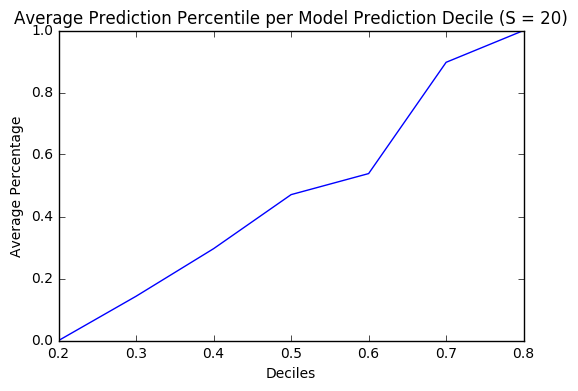

In [64]:
predictions = []
bt = BlockTower([0, 0, 0, 0, 0, 0])
start = time.time()
for i in range(200):
    iloced = df.iloc[i]
    positions = [iloced["Position1"], iloced["Position2"], iloced["Position3"], iloced["Position4"], iloced["Position5"], \
                iloced["Position6"]]
    hitdafloor = []
    for n in range(100):
        copy = positions.copy()
        copy = list(map(lambda x: x + np.random.normal(scale = 20), copy))
        bt.change_x_y(copy)
        hitdafloor.append(bt.simulate())
    predictions.append(len([i for i in hitdafloor if i == True])/len(hitdafloor))  
dfcopy["Deciles"] = predictions
dfcopy["Deciles"] = dfcopy["Deciles"].apply(lambda x: round(x, 1))
df20 = dfcopy.copy()
edited20 = dfcopy.groupby("Deciles").mean().reset_index()[["Deciles", "Prediction"]]
plt.plot(edited20["Deciles"], edited20["Prediction"])
plt.xlabel("Deciles")
plt.ylabel("Average Percentage")
plt.title("Average Prediction Percentile per Model Prediction Decile (S = 20)")
end = time.time()
print("Time Elapsed: " + str(end - start))

Time Elapsed: 144.10074019432068


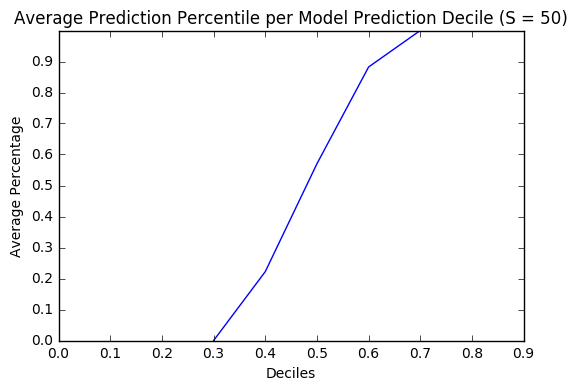

In [60]:
predictions = []
bt = BlockTower([0, 0, 0, 0, 0, 0])
start = time.time()
for i in range(200):
    iloced = df.iloc[i]
    positions = [iloced["Position1"], iloced["Position2"], iloced["Position3"], iloced["Position4"], iloced["Position5"], \
                iloced["Position6"]]
    hitdafloor = []
    for n in range(100):
        copy = positions.copy()
        copy = list(map(lambda x: x + np.random.normal(scale = 50), copy))
        bt.change_x_y(copy)
        hitdafloor.append(bt.simulate())
    predictions.append(len([i for i in hitdafloor if i == True])/len(hitdafloor))  
dfcopy["Deciles"] = predictions
dfcopy["Deciles"] = dfcopy["Deciles"].apply(lambda x: round(x, 1))
edited = dfcopy.groupby("Deciles").mean().reset_index()[["Deciles", "Prediction"]]
plt.plot(edited["Deciles"], edited["Prediction"])
plt.xlabel("Deciles")
plt.ylabel("Average Percentage")
plt.title("Average Prediction Percentile per Model Prediction Decile (S = 50)")
plt.yticks(np.arange(0, 1, 0.1))
plt.xticks(np.arange(0, 1, 0.1))
end = time.time()
print("Time Elapsed: " + str(end - start))

Time Elapsed: 141.641597032547


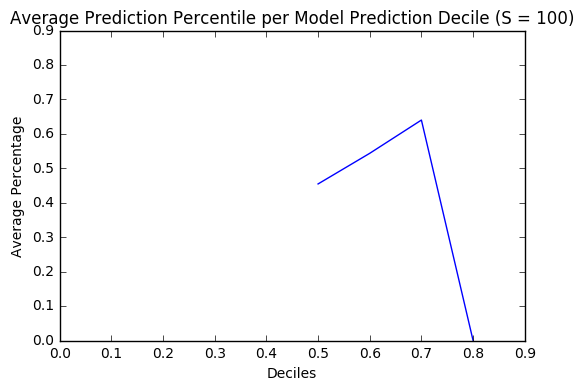

In [61]:
predictions = []
bt = BlockTower([0, 0, 0, 0, 0, 0])
start = time.time()
for i in range(200):
    iloced = df.iloc[i]
    positions = [iloced["Position1"], iloced["Position2"], iloced["Position3"], iloced["Position4"], iloced["Position5"], \
                iloced["Position6"]]
    hitdafloor = []
    for n in range(100):
        copy = positions.copy()
        copy = list(map(lambda x: x + np.random.normal(scale = 100), copy))
        bt.change_x_y(copy)
        hitdafloor.append(bt.simulate())
    predictions.append(len([i for i in hitdafloor if i == True])/len(hitdafloor))  
dfcopy["Deciles"] = predictions
dfcopy["Deciles"] = dfcopy["Deciles"].apply(lambda x: round(x, 1))
edited = dfcopy.groupby("Deciles").mean().reset_index()[["Deciles", "Prediction"]]
plt.plot(edited["Deciles"], edited["Prediction"])
plt.xlabel("Deciles")
plt.ylabel("Average Percentage")
plt.title("Average Prediction Percentile per Model Prediction Decile (S = 100)")
plt.yticks(np.arange(0, 1, 0.1))
plt.xticks(np.arange(0, 1, 0.1))
end = time.time()
print("Time Elapsed: " + str(end - start))

<b> As expected, the higher the standard deviation gets, the worse the model becomes, and the less it reflects our own predictions. S = 20 was around where the model most closely matched my predictions, whilst everything past 20 (50 and 100) had models that lingered around the 50-70% accurate mark. The S = 20 matches as perfectly as it can with my ~70% accuracy rating; a close enough approximation of a y = x line. </b>

# Extra Credit

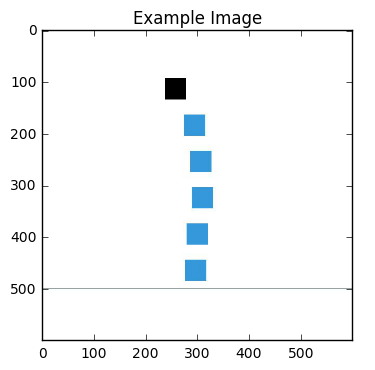

In [82]:
fifties = df20[df20["Deciles"] == 0.5]
blockinstance = BlockTower([0,0,0,0,0,0])

for i in range(20):
    string = str(i)
    iloced = df.iloc[i]
    positions = [iloced["Position1"], iloced["Position2"], \
        iloced["Position3"], iloced["Position4"], iloced["Position5"], \
        iloced["Position6"]]
    blockinstance.change_x_y(positions)
    blockinstance.saveimage(file = string + ".jpg") 
import matplotlib.image as mpimg
img = mpimg.imread("1.jpg")
plt.imshow(img)
plt.title("Example Image")

<b> Created 20 images and surveyed manually because the csv writing code was slightly too intensive on my computer. </b>

In [80]:
emily = [1,1,0,1,0,1,1,0,1,1,0,0,1,0,0,0,1,1,1,0]
victoria = [1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,1,1,0]
mum = [1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,0, 0,1,1,1,1,0,0, 0]
dad = [1,1,1,1,0,1,0,0 ,1,1,0,1,0,1,0,1,1,1,0, 1]
bro = [1,0,0,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,1,1]
means = [np.mean(emily), np.mean(victoria), np.mean(mum),\
         np.mean(dad), np.mean(bro)]
means

[0.55000000000000004,
 0.59999999999999998,
 0.45000000000000001,
 0.65000000000000002,
 0.5]

<b> Surprisingly, my surveyed population got extremely close to around 50%, with my brother getting exactly 50%. This means that my 20 pixel standard deviation prediction model is both close to how I think and how they think. </b>